In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from os import path
from scipy.signal import resample
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
mpl.style.use('seaborn-notebook')
%matplotlib inline
#sorted(mpl.style.available)


#adding local modules
import sys
module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocess.biodarw_feature_extraction import extract_residues, extract_radio
from utils import load_biodarw

# setting up variables
doc_path = "/data/elekin/doc"
coefficients=17

%matplotlib inline

In [2]:
#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/residues_{}_20220905.csv".format(coefficients))
features = features.set_index(features.columns[0]).astype(np.float32)
print("Loaded data from CSV")
features.head(1)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,0.0,139.606018,12.253823,74.690514,11.408071,53.418941,16.638002,35.400345,12.710705,31.302645,...,97.716553,114.776398,67.099197,47.384319,97.479012,149.785263,65.237343,76.28756,109.27401,603.564941


Loading labels based on clinic, residues and features from residues.


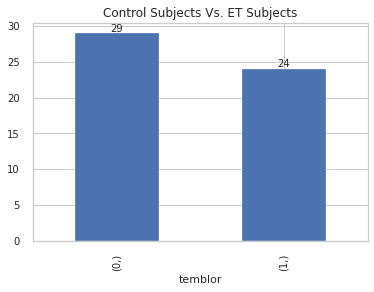

In [3]:
y = pd.read_csv("/data/elekin/data/results/handwriting/binary_labels_20220903.csv", index_col=0)
y = (y == 'si').astype('int8')
ax = y.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

Verify that the data calculated with airflow is correct

<AxesSubplot:>

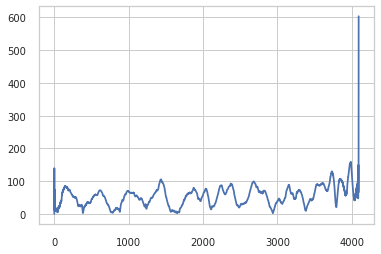

In [4]:
features.loc['C01_1'].plot()

<AxesSubplot:>

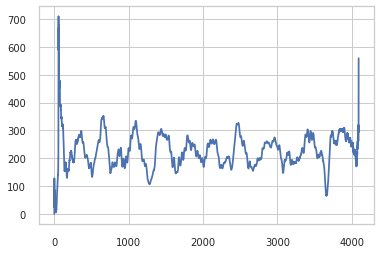

In [5]:
features.loc['T027'].plot()

In [6]:
features.shape,y.shape

((53, 4096), (53, 1))

In [7]:
from sklearn.discriminant_analysis import LinearDisaxcriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
random_state = 0

X_train=features.values
y_train=y.values.ravel()

In [8]:
# Reduce dimension with LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
X_train_lda=lda.transform(X_train)

In [9]:
df_lda=pd.DataFrame(X_train_lda, columns=["LDA1"])#temblor
#df_lda=pd.DataFrame(X_train_lda, columns=["component1", "component2"])#level
df_lda["labels"]=y_train
df_lda.head()

,LDA1,labels
0,-0.364690,0
1,1.196517,0
2,-3.454280,0
3,-0.855998,0
4,-1.946901,0


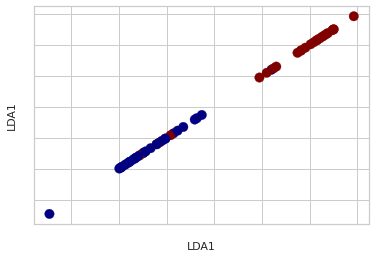

In [10]:
ax = df_lda.plot.scatter(x="LDA1", y="LDA1", c="labels", cmap="jet", s=90, colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

In [11]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=3, random_state=random_state))
# Fit the method's model
pca.fit(X_train, y_train)
X_train_pca=pca.transform(X_train)

In [12]:
df_pca=pd.DataFrame(X_train_pca, columns=["PCA0", "PCA1","PCA2"])
df_pca["labels"]=y_train.ravel()
df_pca.head()

,PCA0,PCA1,PCA2,labels
0,-63.588371,0.008614,0.124200,0
1,-60.407715,0.455233,0.185744,0
2,-58.490692,0.329033,0.092636,0
3,-58.328060,-0.292655,0.780599,0
4,-60.847626,0.081344,0.294381,0


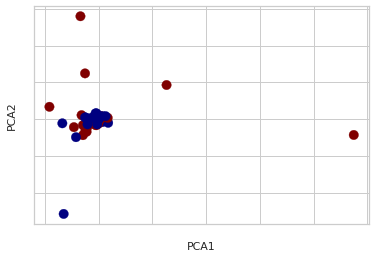

In [13]:
ax = df_pca.plot.scatter(x="PCA1", y="PCA2", c="labels", cmap="jet", s=90, colorbar=False)
ax.xaxis.set_ticklabels([])
_ = ax.yaxis.set_ticklabels([])

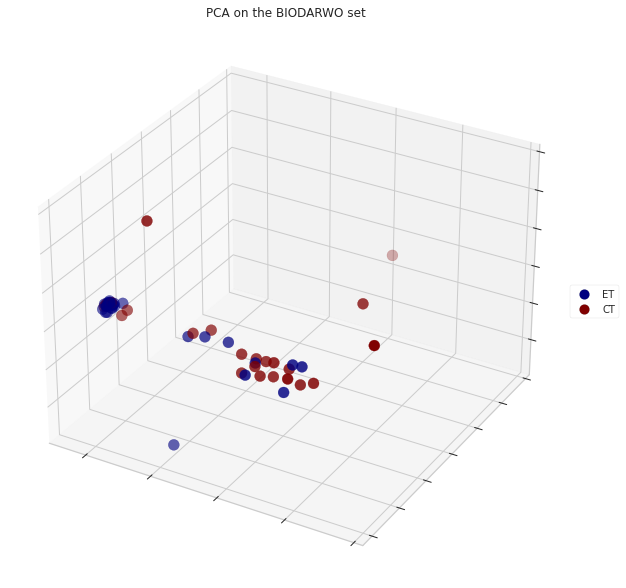

In [14]:
# Plot initialisation
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')


sc=ax.scatter(df_pca['PCA0'], 
              df_pca['PCA1'], 
              df_pca['PCA2'], c=df_pca.labels, cmap="jet", s=120)
    
# label the axes
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_zlabel(None)
ax.set_title("PCA on the BIODARWO set")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

colors = [sc.cmap(sc.norm(i)) for i in [0.0, 1.0, 2.0]]

custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
import collections
legend = ['ET','CT']#temblor
ax.legend(custom_lines, legend, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [15]:
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


score='accuracy'
X = X_train
y = y_train

loo = LeaveOneOut()

In [16]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.33, random_state=38)
Counter(ys_train), Counter(ys_test)

(Counter({0: 21, 1: 14}), Counter({0: 8, 1: 10}))

$$ Accuracy: \frac{TP + TN}{TP + TN + FP + FN} $$ 

$$    Recall: \frac{TP}{TP + FN} $$

$$    Precision: \frac{TP}{TP + FP} $$

$$    Specifity: \frac{TN}{TN + FP} $$

Where TP, TN, FP, and FN are, respectively, the true positive, true negative, false positive and false negative values
of the confusion matrix. The positive case corresponds to the ET subjects while the negative case to the CT ones.

**Equations explained**

* Sensitivity/recall – how good a test is at detecting the positives. A test can cheat and maximize this by always returning “positive”. From the whole positive cases how many of them where properly detected.
* Specificity – how good a test is at avoiding false alarms. A test can cheat and maximize this by always returning “negative”.
* Precision – how many of the positively classified were relevant. A test can cheat and maximize this by only returning positive on one result it’s most confident in. 

The cheating is resolved by looking at both relevant metrics instead of just one. E.g. the cheating 100% sensitivity that always says “positive” has 0% specificity.


### SVM-rbf

Leaving one out validation

In [17]:
reports = dict()
# predictive model
clf = SVC(kernel='rbf', gamma=0.2, C=10**3)

In [18]:
cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)
print("CV train score svm: {}".format(cv['train_score'].mean()))
print("CV test score svm: {}".format(cv['test_score'].mean()))

CV train score svm: 1.0
CV test score svm: 0.5471698113207547


Hold hout validation

In [19]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [20]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['svm-rbf'] = report

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

### RandomForest

Leaving one out validation

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score RandomForest: {}".format(cv['train_score'].mean()))
print("CV test score RandomForest: {}".format(cv['test_score'].mean()))

CV train score RandomForest: 1.0
CV test score RandomForest: 0.6226415094339622


Holdout validation

In [22]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [23]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['randomforest'] = report

### KNN-5

Leaving one out validation

In [24]:
clf = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='euclidean')

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score knn: {}".format(cv['train_score'].mean()))
print("CV test score knn: {}".format(cv['test_score'].mean()))

CV train score knn: 0.788098693759071
CV test score knn: 0.6226415094339622


Holdout validation

In [25]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [26]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['knn'] = report

### LDA

Leaving one out validation

In [27]:
clf.fit(Xs_train, ys_train)
clf = LDA()

cv = cross_validate(clf, X, y, cv=loo, scoring=score, return_train_score=True, n_jobs=-1)

print("CV train score LDA: {}".format(cv['train_score'].mean()))
print("CV test score LDA: {}".format(cv['test_score'].mean()))

CV train score LDA: 0.9245283018867921
CV test score LDA: 0.5471698113207547


Holdout validation

In [28]:
clf.fit(Xs_train, ys_train)
predictions = clf.predict(Xs_test)
#cm = confusion_matrix(ys_test, predictions, labels=clf.classes_)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
#disp.plot(cmap=plt.cm.Blues)
#_=plt.axis('off')

In [29]:
report = classification_report(ys_test, predictions, digits=4, target_names=['Negative','Positive'], output_dict=True)
report['loo']= {}
report['loo']['acc']=cv['train_score'].mean()
report['loo']['val_acc']=cv['test_score'].mean()
reports['lda'] = report

In [30]:
for key in reports:
    print('{}'.format(key))

svm-rbf
randomforest
knn
lda


In [31]:
for key in reports:
    print('{}'.format(reports[key]['loo']['val_acc']))

0.5471698113207547
0.6226415094339622
0.6226415094339622
0.5471698113207547


In [32]:
for key in reports:
    print('{}'.format(reports[key]['accuracy']))

0.4444444444444444
0.5555555555555556
0.5
0.4444444444444444


In [33]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['recall']))

0.0
0.6
0.3
0.2


In [34]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['recall']))

1.0
0.5
0.75
0.75


In [35]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['precision']))

0.0
0.6
0.6
0.5


In [36]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['precision']))

0.4444444444444444
0.5
0.46153846153846156
0.42857142857142855


In [37]:
for key in reports:
    print('{}'.format(reports[key]['Positive']['f1-score']))

0.0
0.6
0.4
0.28571428571428575


In [38]:
for key in reports:
    print('{}'.format(reports[key]['Negative']['f1-score']))

0.6153846153846153
0.5
0.5714285714285714
0.5454545454545454
